In [ ]:
# Connect to Drive

from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive

Mounted at /content/drive


In [1]:
%%capture
!pip3 install wandb -qqq

#RL$^2$: Fast Reinforcement Learning via Slow Reinforcement Learning

## Utilities


In [2]:
def ema(data, alpha=0.9):
  '''
  Function to calculate exponential moving averages
  Args:
  - data : List of rewards
  - alpha : ema factor
  Returns
  - averages(list) : emas of rewards
  '''
  averages = []
  for i, r in enumerate(data):
    if i == 0:
      averages.append(r)
    else:
      avg = (1-alpha)*r + alpha*averages[i-1]
      averages.append(avg)
  return averages

## Tabular MDPs

We use Tabular MDPs for all the experiments. All the environments have been taken from [TabulaRL](https://github.com/iosband/TabulaRL). The original paper uses the same environments for some of the experiments

In [3]:
# Taken and adpated from https://github.com/iosband/TabulaRL/blob/master/src/environment.py

import random

'''
Implementation of a basic RL environment.
Rewards are all normal.
Transitions are multinomial.
author: iosband@stanford.edu
'''

import numpy as np

#-------------------------------------------------------------------------------


class Environment(object):
    '''General RL environment'''

    def __init__(self):
        pass

    def reset(self):
        pass

    def advance(self, action):
        '''
        Moves one step in the environment.
        Args:
            action
        Returns:
            reward - double - reward
            newState - int - new state
            pContinue - 0/1 - flag for end of the episode
        '''
        return 0, 0, 0


#-------------------------------------------------------------------------------


class TabularMDP(Environment):
    '''
    Tabular MDP
    R - dict by (s,a) - each R[s,a] = (meanReward, sdReward)
    P - dict by (s,a) - each P[s,a] = transition vector size S
    '''

    def __init__(self, nState, nAction, epLen):
        '''
        Initialize a tabular episodic MDP
        Args:
            nState  - int - number of states
            nAction - int - number of actions
            epLen   - int - episode length
        Returns:
            Environment object
        '''

        self.nState = nState
        self.nAction = nAction
        self.epLen = epLen

        self.timestep = 0
        self.state = 0

        # Now initialize R and P
        self.R = {}
        self.P = {}
        for state in range(nState):
            for action in range(nAction):
                self.R[state, action] = (1, 1)
                self.P[state, action] = np.ones(nState) / nState


    def reset(self):
        '''Reset the environment'''
        self.timestep = 0
        self.state = 0

        return self.state

    def advance(self, action):
        '''
        Move one step in the environment
        Args:
        action - int - chosen action
        Returns:
        reward - double - reward
        newState - int - new state
        pContinue - 0/1 - flag for end of the episode
        '''
        if self.R[self.state, action][1] < 1e-9:
            # Hack for no noise
            reward = self.R[self.state, action][0]
        else:
            reward = np.random.normal(loc=self.R[self.state, action][0],
                                      scale=self.R[self.state, action][1])
        newState = np.random.choice(self.nState, p=self.P[self.state, action])

        # Update the environment
        self.state = newState
        self.timestep += 1

        if self.timestep == self.epLen:
            pContinue = 1
            self.reset()
        else:
            pContinue = 0

        return newState, reward, pContinue, None

    def compute_qVals(self):
        '''
        Compute the Q values for the environment
        Args:
            NULL - works on the TabularMDP
        Returns:
            qVals - qVals[state, timestep] is vector of Q values for each action
            qMax - qMax[timestep] is the vector of optimal values at timestep
        '''
        qVals = {}
        qMax = {}

        qMax[self.epLen] = np.zeros(self.nState)

        for i in range(self.epLen):
            j = self.epLen - i - 1
            qMax[j] = np.zeros(self.nState)

            for s in range(self.nState):
                qVals[s, j] = np.zeros(self.nAction)

                for a in range(self.nAction):
                    qVals[s, j][a] = self.R[s, a][0] + np.dot(self.P[s, a], qMax[j + 1])

                qMax[j][s] = np.max(qVals[s, j])
        return qVals, qMax

#-------------------------------------------------------------------------------
# Benchmark environments

def make_tabularEnv(nState=10, meanReward=1, transitionParameter=1, epLen=20):
  '''
  Makes a Tabular MDP
  Args:
    nState - Number of states
    meanReward - Mean of the reward distribution
    transitionParameter - <>
  Returns:
    A regular Tabular MDP environments with rewards following a gaussian distribution 
    with a standard deviation 1 and expected reward = meanReward 
  '''
  nAction = 2
  R_true = {}
  P_true = {}

  for s in range(nState):
    for a in range(nAction):
      R_true[s, a] = (meanReward, 1)
      P_true[s, a] = np.zeros(nState)

  # Transitions
  for s in range(nState):
    P_true[s, 0][max(0, s-1)] = 1.

  for s in range(1, nState - 1):
    P_true[s, 1][min(nState - 1, s + 1)] = 0.35
    P_true[s, 1][s] = 0.6
    P_true[s, 1][max(0, s-1)] = 0.05

  P_true[0, 1][0] = 0.4
  P_true[0, 1][1] = 0.6
  P_true[nState - 1, 1][nState - 1] = 0.6
  P_true[nState - 1, 1][nState - 2] = 0.4

  tabularEnv = TabularMDP(nState, nAction, epLen)
  tabularEnv.R = R_true
  tabularEnv.P = P_true
  tabularEnv.reset()

  return tabularEnv

def make_riverSwim(epLen=20, nState=6):
    '''
    Makes the benchmark RiverSwim MDP.
    Args:
        NULL - works for default implementation
    Returns:
        riverSwim - Tabular MDP environment
    '''
    nAction = 2
    R_true = {}
    P_true = {}

    for s in range(nState):
        for a in range(nAction):
            R_true[s, a] = (0, 0)
            P_true[s, a] = np.zeros(nState)

    # Rewards
    r = random.uniform(1, 9)
    R_true[0, 0] = (r / 1000, 0)
    R_true[nState - 1, 1] = (1, 0)

    # Transitions
    for s in range(nState):
        P_true[s, 0][max(0, s-1)] = 1.

    t1 = random.uniform(0, 1)
    t2 = random.uniform(0, 1-t1)
    for s in range(1, nState - 1):
        P_true[s, 1][min(nState - 1, s + 1)] = t1
        P_true[s, 1][s] = t2
        P_true[s, 1][max(0, s-1)] = 1-t1-t2

    t3 = random.uniform(0, 1)
    P_true[0, 1][0] = t3
    P_true[0, 1][1] = 1 - t3
    P_true[nState - 1, 1][nState - 1] = 1 - t3
    P_true[nState - 1, 1][nState - 2] = t3

    riverSwim = TabularMDP(nState, nAction, epLen)
    riverSwim.R = R_true
    riverSwim.P = P_true
    riverSwim.reset()

    return riverSwim

## Constructing the GRUPolicy

The input to the policy is formed by concatenating the observation, action, reward and the episode termination flag $(s_{t+1}, a_{t}, r_{t}, d_{t})$. The observation and the actions are encoded into one hot vectors and then concatenated. This input then along with the hidden state $h_{t+1}$ produces the action $a_{t+1}$ which is then applied to the environment.


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

random.seed(10)
np.random.seed(10)
torch.manual_seed(10)

class GRUPolicy(nn.Module):
  def __init__(self, hidden_size, env):
    super(GRUPolicy, self).__init__()
    self.env = env
    self.obs_embed_size = self.env.nState
    self.action_embed_size = self.env.nAction
    self.input_dim = self.obs_embed_size + self.action_embed_size + 1 + 1
    self.hidden_size = hidden_size
    self.gru = nn.GRUCell(self.input_dim, self.hidden_size, bias=True)
    self.fc1 = nn.Linear(self.hidden_size, self.env.nAction)
    self.reset_hidden_state()
  
  def make_input(self, obs, action, reward, done):
    reward = reward.unsqueeze(1)
    action = F.one_hot(action.long(), num_classes=self.env.nAction)
    action = action.to(dtype).to(device)
    done = done.unsqueeze(1)
    input = torch.cat((obs, action, reward, done), dim=1).to(dtype).to(device)
    return input

  def reset_hidden_state(self):
    self.h = torch.zeros(self.hidden_size).reshape(1, self.hidden_size)
    self.h = self.h.to(dtype).to(device)

  def forward(self, obs, action, reward, done, batch=False):
    input = self.make_input(obs, action, reward, done)
    if batch:
      hidden = self.h.clone()
      hidden = torch.cat(input.shape[0]*[self.h])
      hidden = hidden.detach()
      hidden = F.relu(self.gru(input, hidden))
      hidden = hidden.to(dtype).to(device)
      hidden.detach_()
      action =self.fc1(hidden)
      return action

    self.h = F.relu(self.gru(input, self.h))
    self.h = self.h.to(dtype).to(device)
    self.h.detach_()
    action = self.fc1(self.h)

    return action

## PPO with GRUPolicy

We use a customm implementation of [PPO](https://spinningup.openai.com/en/latest/algorithms/ppo.html) as the RL algorithms for the inner loop. The original paper uses [TRPO](https://spinningup.openai.com/en/latest/algorithms/trpo.html) as the RL optimisation algorithm for the inner loop. These class of algorithms require relatively less hyperparameter tuning and can be used for environments with both discrete and continuous action spaces 

In [5]:
# PPO Module adapted from https://github.com/threewisemonkeys-as/myrl/blob/master/ppo/ppo_torch.py

import datetime
import time
from collections import deque, namedtuple
from itertools import count
from pathlib import Path
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
!wandb.login

random.seed(10)
np.random.seed(10)
torch.manual_seed(10)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double


class Trajectory:
    def __init__(
        self, observations=[], actions=[], rewards=[], dones=[], logits=[],
    ):
        self.obs = observations
        self.a = actions
        self.r = rewards
        self.d = dones
        self.logits = logits
        self.len = 0

    def add(
        self,
        obs: torch.Tensor,
        a: torch.Tensor,
        r: torch.Tensor,
        d: torch.Tensor,
        logits: torch.Tensor,
    ):
        self.obs.append(obs)
        self.a.append(a)
        self.r.append(r)
        self.d.append(d)
        self.logits.append(logits)
        self.len += 1

    def disc_r(self, gamma, normalize=False):
        disc_rewards = []
        r = 0.0
        for reward in self.r[::-1]:
            r = reward + gamma * r
            disc_rewards.insert(0, r)
        disc_rewards = torch.tensor(disc_rewards, device=device, dtype=dtype)
        if normalize:
            disc_rewards = (disc_rewards - disc_rewards.mean()) / (
                disc_rewards.std() + np.finfo(np.float32).eps
            )
        return disc_rewards

    def __len__(self):
        return self.len

# Hyperparameters
HIDDEN_SIZE = 4
EPOCHS = 400
MAX_TRAJ_LENGTH = 1000
EPISODES_PER_EPOCH = 64
VALUE_HIDDEN_LAYERS = 32
N_POLICY_UPDATES = 16
N_VALUE_UPDATES = 16
GAMMA = 0.99
EPSILON = 0.1
VALUE_FN_LEARNING_RATE = 1e-3
POLICY_LEARNING_RATE = 3e-4

wandb.init(project="ppo", config={
    "trials": 10,
    "hidden_size": 4,
    "env_constructor": make_riverSwim,
    "max_traj_length": 1000,
    "epochs_per_trial": 200,
    "epochs": 700,
    "episodes_per_epoch": 64,
    "value_hidden_layers": 32,
    "n_policy_updates": 16,
    "n_value_updates": 16,
    "gamma": 0.99,
    "epsilon": 0.1,
    "value_fn_learning_rate": 1e-3,
    "policy_learning_rate": 3e-4,
    "nState": 10,
    "epLen": 20,
  })

config = wandb.config

# Model
class PPOGRU:
    def __init__(
        self,
        env,
        policy_hidden_layers=None,
        value_hidden_layers=None,
        policy=None,
        value=None,
    ):
        self.env = env
        self.env_name = 'TabularEnv'

        if policy_hidden_layers is None:
          if policy is None:
            raise Exception("Unable to construct policy network!")
          else:
            self.policy = policy.to(dtype).to(device)
        else:
          self.policy = (
            nn.Sequential(
                nn.Linear(env.nState, policy_hidden_layers),
                nn.Dropout(p=0.6),
                nn.ReLU(),
                nn.Linear(policy_hidden_layers, env.nAction),
            )
            .to(device)
            .to(dtype)
          )

        if value_hidden_layers is None:
          if value is None:
            raise Exception("Unable to construct value network!")
          else:
            self.value = value
        else:
          self.value = (
            nn.Sequential(
                nn.Linear(self.env.nState, value_hidden_layers),
                nn.Dropout(p=0.6),
                nn.ReLU(),
                nn.Linear(value_hidden_layers, 1),
            )
            .to(device)
            .to(dtype)
          )        

    def _update(self, batch, hp, policy_optim, value_optim):
        # process batch
        obs = [torch.stack(traj.obs)[:-1] for traj in batch]
        disc_r = [traj.disc_r(hp["gamma"], normalize=True) for traj in batch]
        a = [torch.stack(traj.a) for traj in batch]
        d = [torch.stack(traj.d) for traj in batch]
        r = [torch.stack(traj.r) for traj in batch]
        #print(f"Shape of a[0] : {a[0].shape}")
        #print(f"Shape of d[0] : {d[0].shape}")
        #print(f"Shape of obs[0] : {obs[0].shape}")
        #print(f"Shape of r[0] : {r[0].shape}")
        with torch.no_grad():
            v = [self.value(o) for o in obs]
            adv = [disc_r[i] - v[i] for i in range(len(batch))]
            old_logits = [torch.stack(traj.logits) for traj in batch]
            old_logprobs = [
                -F.cross_entropy(old_logits[i], a[i]) for i in range(len(batch))
            ]

        # update policy
        for j in range(hp["n_policy_updates"]):
            policy_loss = torch.zeros(1, device=device, dtype=dtype, requires_grad=True)
            for i, traj in enumerate(batch):
                curr_logits = self.policy(obs[i], a[i], r[i], d[i], batch=True)
                curr_logprobs = -F.cross_entropy(curr_logits, a[i])
                ratio = torch.exp(curr_logprobs - old_logprobs[i])
                clipped_ratio = torch.clamp(ratio, 1 - hp["epsilon"], 1 + hp["epsilon"])
                policy_loss = (
                    policy_loss
                    + torch.min(ratio * adv[i], clipped_ratio * adv[i]).mean()
                )

            policy_loss = policy_loss / len(batch)
            policy_optim.zero_grad()
            policy_loss.backward()
            policy_optim.step()

        # update value function
        for j in range(hp["n_value_updates"]):
            value_loss = torch.zeros(1, device=device, dtype=dtype, requires_grad=True)
            for i in range(len(batch)):
                v = self.value(obs[i]).view(-1)
                value_loss = value_loss + F.mse_loss(v, disc_r[i])
            value_loss = value_loss / len(batch)
            value_optim.zero_grad()
            value_loss.backward()
            value_optim.step()

        return policy_loss.item(), value_loss.item()

    def train(
        self,
        epochs=EPOCHS,
        episodes_per_epoch=EPISODES_PER_EPOCH,
        n_value_updates=N_VALUE_UPDATES,
        n_policy_updates=N_POLICY_UPDATES,
        value_lr=VALUE_FN_LEARNING_RATE,
        policy_lr=POLICY_LEARNING_RATE,
        gamma=GAMMA,
        epsilon=EPSILON,
        max_traj_length=MAX_TRAJ_LENGTH,
        log_dir="./logs/",
        config=config,
        RENDER=False,
        PLOT_REWARDS=True,
        VERBOSE=False,
    ):
        """ Trains both policy and value networks """
        hp = locals()
        start_time = datetime.datetime.now()
        print(
            f"Start time: {start_time:%d-%m-%Y %H:%M:%S}"
            f"\nTraining model on {self.env_name} | "
            f"Observation Space: Discrete({self.env.nState}) | "
            f"Action Space: {self.env.nAction}\n"
            f"Hyperparameters: \n{hp}\n"
        )
        log_path = Path(log_dir)
        log_path.mkdir(parents=True, exist_ok=False)

        self.policy.train()
        self.value.train()
        value_optim = torch.optim.Adam(self.value.parameters(), lr=value_lr)
        policy_optim = torch.optim.Adam(self.policy.parameters(), lr=policy_lr)
        rewards = []
        e = 0

        try:
            for epoch in range(epochs):
                epoch_rewards = []
                batch = []

                # Sample trajectories
                for e in range(episodes_per_epoch):
                    # initialise tracking variables
                    obs = self.env.reset()
                    obs = torch.tensor(obs, device=device)
                    obs = F.one_hot(obs, num_classes=self.env.nState)
                    obs = obs.to(dtype)
                    traj = Trajectory([obs], [], [], [], [])
                    obs = obs.unsqueeze(0)
                    d = torch.tensor([0], device=device, dtype=dtype)
                    r = torch.tensor([0], device=device, dtype=dtype)
                    a = torch.tensor([0], device=device, dtype=dtype)
                    e += 1

                    # run for single trajectory
                    for i in range(max_traj_length):

                        a_logits = self.policy(obs, a, r, d)
                        a_logits = a_logits.reshape(self.env.nAction)
                        a = torch.distributions.Categorical(logits=a_logits).sample()
                        obs, r, d, _ = self.env.advance(a.item())

                        obs = torch.tensor(obs, device=device)
                        obs = F.one_hot(obs, num_classes=self.env.nState).to(device)
                        obs = obs.to(dtype)
                        r = torch.tensor(r, device=device, dtype=dtype)
                        d = torch.tensor(d, device=device, dtype=dtype)
                        traj.add(obs, a, r, d, a_logits)
                        
                        a = a.reshape(1)
                        r = r.reshape(1)
                        d = d.reshape(1)
                        obs = obs.unsqueeze(0)

                        if d:
                            break

                    epoch_rewards.append(sum(traj.r))
                    batch.append(traj)

                # Update value and policy
                p_loss, v_loss = self._update(
                    batch, hp, policy_optim, value_optim
                )

                # Log rewards and losses
                epoch_rewards_tensor = torch.tensor(epoch_rewards, device=device, dtype=dtype)
                avg_episode_reward = torch.mean(epoch_rewards_tensor[-episodes_per_epoch:])
                rewards.append(avg_episode_reward)
                
                wandb.log({
                    "policy_loss": p_loss,
                    "value_loss": v_loss,
                    "reward": avg_episode_reward,
                    "epoch": epoch,
                })

                if VERBOSE and (epoch == 0 or ((epoch + 1) % (epochs / 10)) == 0):
                    print(
                        f"Epoch {epoch+1}: Average Episodic Reward = {avg_episode_reward:.2f} |"
                        f" Value Loss = {p_loss:.2f} |"
                        f" Policy Loss = {v_loss:.2f}"
                    )

        except KeyboardInterrupt as _:
            print("\nTraining Interrupted!\n")

        finally:
            #self.env.close()
            print(
                f"\nTraining Completed in {(datetime.datetime.now() - start_time).seconds} seconds"
            )
            self.save(
                log_path.joinpath(f"{self.__class__.__name__}_{self.env_name}.pt")
            )
            if PLOT_REWARDS:
                plt.plot(rewards)
                plt.savefig(
                    log_path.joinpath(
                        f"{self.__class__.__name__}_{self.env_name}_reward_plot.png"
                    )
                )
            return rewards

    def save(self, path):
        """ Save model parameters """
        torch.save(
            {
                "policy_state_dict": self.policy.state_dict(),
                "value_state_dict": self.value.state_dict(),
            },
            path,
        )
        print(f"\nSaved model parameters to {path}")

    def load(self, path=None):
        """ Load model parameters """
        if path is None:
            path = f"./models/{self.__class__.__name__}_{self.env_name}.pt"
        checkpoint = torch.load(path)
        self.policy.load_state_dict(checkpoint["policy_state_dict"])
        self.value.load_state_dict(checkpoint["value_state_dict"])
        print(f"\nLoaded model parameters from {path}")

    def eval(self, episodes, render=False):
        """ Evaluates model performance """

        print(f"\nEvaluating model for {episodes} episodes ...\n")
        start_time = datetime.datetime.now()
        self.policy.eval()
        rewards = []

        for episode in range(episodes):

            observation = self.env.reset()
            observation = torch.tensor(observation, device=device)
            observation = F.one_hot(observation, num_classes=self.env.nState).to(dtype)
            observation = observation.unsqueeze(0)
            done = torch.tensor([0], device=device, dtype=dtype)
            reward = torch.tensor([0], device=device, dtype=dtype)
            action = torch.tensor([0], device=device, dtype=dtype)
            episode_rewards = []

            while not done:
                if render:
                    self.env.render()

                logits = self.policy(observation, action, reward, done)
                logits = logits.reshape(self.env.nAction)
                action = torch.distributions.Categorical(logits=logits).sample()
                next_observation, reward, done, _ = self.env.advance(action.item())
                episode_rewards.append(float(reward))
                next_observation = torch.tensor(
                    next_observation, device=device
                )
                next_observation = F.one_hot(next_observation, num_classes=self.env.nState).to(dtype)
                observation = next_observation
                reward = torch.tensor(reward, device=device, dtype=dtype)
                done = torch.tensor(done, device=device, dtype=dtype)
                action = action.reshape(1)
                reward = reward.reshape(1)
                done = done.reshape(1)
                observation = observation.unsqueeze(0)

            total_episode_reward = sum(episode_rewards)
            rewards.append(total_episode_reward)
            print(
                f"Episode {episode+1}: Total Episode Reward = {total_episode_reward:.2f}"
            )
            rewards.append(total_episode_reward)
            return rewards

        #env.close()
        print(f"\nAverage Reward for an episode = {np.mean(rewards):.2f}")
        print(
            f"Evaluation Completed in {(datetime.datetime.now() - start_time).seconds} seconds"
        )
        return rewards

/bin/bash: wandb.login: command not found


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Start time: 03-05-2021 06:44:35
Training model on TabularEnv | Observation Space: Discrete(10) | Action Space: 2
Hyperparameters: 
{'self': <__main__.PPOGRU object at 0x7fdd1b6bc690>, 'epochs': 500, 'episodes_per_epoch': 64, 'n_value_updates': 16, 'n_policy_updates': 16, 'value_lr': 0.001, 'policy_lr': 0.0003, 'gamma': 0.99, 'epsilon': 0.1, 'max_traj_length': 1000, 'log_dir': './logs/ppo_gru_policy', 'config': {'trials': 10, 'hidden_size': 4, 'env_constructor': '__main__.make_riverSwim', 'max_traj_length': 1000, 'epochs_per_trial': 200, 'epochs': 700, 'episodes_per_epoch': 64, 'value_hidden_layers': 32, 'n_policy_updates': 16, 'n_value_updates': 16, 'gamma': 0.99, 'epsilon': 0.1, 'value_fn_learning_rate': 0.001, 'policy_learning_rate': 0.0003, 'nState': 10, 'epLen': 20}, 'RENDER': False, 'PLOT_REWARDS': True, 'VERBOSE': True, 'TENSORBOARD_LOG': True}

Epoch 1: Average Episodic Reward = 0.02 | Value Loss = -0.03 | Policy Loss = 0.85
Epoch 50: Average Episodic Reward = 0.04 | Value Loss 

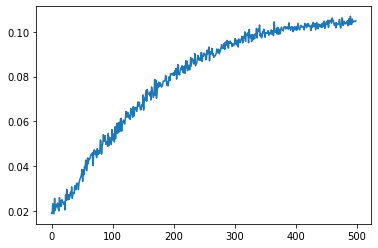

In [6]:
random.seed(10)
np.random.seed(10)
torch.manual_seed(10)

env = make_riverSwim(nState=10, epLen=20)
policy  = GRUPolicy(hidden_size=4, env=env).to(dtype).to(device)
model = PPOGRU(env, policy=policy, value_hidden_layers=VALUE_HIDDEN_LAYERS)
vanilla_ppo_train_rewards = model.train(epochs=500, VERBOSE=True, PLOT_REWARDS=True, log_dir='./logs/ppo_gru_policy')
vanilla_ppo_test_rewards = model.eval(10)

# RL$^2$

In [19]:
'''
Author: Vedant Shah
Email: vedantshah2012@gmail.com
'''

random.seed(10)
np.random.seed(10)
torch.manual_seed(10)

# Hyperparameters
HIDDEN_SIZE = 4
MAKE_ENV = make_riverSwim
VALUE_HIDDEN_LAYERS = 32
POLICY_HIDDEN_LAYERS = 32

# Meta Train Hyperparameters
MTR_TRIALS = 10
MTR_MAX_TRAJ_LENGTH = 1000
MTR_EPOCHS = 5
MTR_EPISODES_PER_EPOCH = 2
MTR_N_POLICY_UPDATES = 16
MTR_N_VALUE_UPDATES = 16
MTR_GAMMA = 0.99
MTR_EPSILON = 0.1
MTR_VALUE_FN_LEARNING_RATE = 1e-3
MTR_POLICY_LEARNING_RATE = 3e-4

# Meta Test Hyperparameters
MTE_EPOCHS = 400
MTE_EPISODES_PER_EPOCH = 64
MTE_N_VALUE_UPDATES = 16
MTE_N_POLICY_UPDATES = 16
MTE_GAMMA = 0.99
MTE_EPSILON = 0.1
MTE_VALUE_FN_LEARNING_RATE = 1e-3
MTE_POLICY_LEARNING_RATE = 3e-4
MTE_MAX_TRAJ_LENGTH = 1000

wandb.init(project='rl2', config={
    'HIDDEN_SIZE': 4,
    'MAKE_ENV': make_riverSwim,
    'VALUE_HIDDEN_LAYERS': 32,
    'MTR_TRIALS': 10,
    'MTR_MAX_TRAJ_LENGTH': 1000,
    'MTR_EPOCHS': 5,
    'MTR_EPISODES_PER_EPOCH': 2,
    'MTR_N_POLICY_UPDATES': 16,
    'MTR_N_VALUE_UPDATES': 16,
    'MTR_GAMMA': 0.99,
    'MTR_EPSILON': 0.1,
    'MTR_VALUE_FN_LEARNING_RATE': 1e-3,
    'MTR_POLICY_LEARNING_RATE': 3e-4,
    'MTE_EPOCHS': 200,
    'MTE_EPISODES_PER_EPOCH': 4,
    'MTE_N_VALUE_UPDATES': 16,
    'MTE_N_POLICY_UPDATES': 16,
    'MTE_GAMMA': 0.99,
    'MTE_EPSILON': 0.1,
    'MTE_VALUE_FN_LEARNING_RATE': 1e-3,
    'MTE_POLICY_LEARNING_RATE': 3e-4,
    'MTE_MAX_TRAJ_LENGTH': 1000
})

config = wandb.config

class RL2:
  def __init__(self,  
               hidden_size=HIDDEN_SIZE, 
               value_hidden_layers=VALUE_HIDDEN_LAYERS, 
               policy_hidden_layers=POLICY_HIDDEN_LAYERS, 
               policy_type='recurrent', 
               make_env=MAKE_ENV, 
               log_dir=f'./logs/'):
    
    self.log_dir = log_dir
    self.make_env = make_env
    dummy_env = make_env(nState=10, epLen=20)
    self.policy_type = policy_type
    if policy_type == 'recurrent':
      self.policy = GRUPolicy(hidden_size=hidden_size, env=dummy_env).to(dtype).to(device)
    elif policy_type == 'mlp':
      self.policy = (
              nn.Sequential(
                  nn.Linear(dummy_env.nState, policy_hidden_layers),
                  nn.Dropout(p=0.6),
                  nn.ReLU(),
                  nn.Linear(policy_hidden_layers, dummy_env.nAction),
              )
              .to(device)
              .to(dtype)
          )
    self.value = (
            nn.Sequential(
                nn.Linear(dummy_env.nState, value_hidden_layers),
                nn.Dropout(p=0.6),
                nn.ReLU(),
                nn.Linear(value_hidden_layers, 1),
            )
            .to(device)
            .to(dtype)
          )

  def meta_train(self, 
                 trials=MTR_TRIALS, 
                 epochs_per_trial=MTR_EPOCHS, 
                 episodes_per_epoch=MTR_EPISODES_PER_EPOCH, 
                 n_value_updates=MTR_N_VALUE_UPDATES, 
                 n_policy_updates=MTR_N_POLICY_UPDATES,
                 value_lr=MTR_VALUE_FN_LEARNING_RATE, 
                 policy_lr=MTR_POLICY_LEARNING_RATE, 
                 gamma=MTR_GAMMA, 
                 epsilon=MTR_EPSILON, 
                 max_traj_length=MTR_MAX_TRAJ_LENGTH,
                 reset_hidden_state=True,
                 PLOT_REWARDS=False,
                 VERBOSE=True):

    env = self.make_env(nState=10, epLen=20)
    if self.policy_type == 'recurrent':
      agent = PPOGRU(env, policy=self.policy, value=self.value)
    elif self.policy_type == 'mlp':
      agent = PPOMLP(env, policy=self.policy, value=self.value)
    start_time = datetime.datetime.now()
    
    for t in range(trials):
      env = self.make_env(nState=10, epLen=20)
      print(f"\nTRIAL NUMBER : {t+1}\n")
           # f"\nREWARDS : {env.R} |"
           # f"\nTRANSITION PROBABILITIES : {env.P}")
      agent.env = env
      if reset_hidden_state and self.policy_type == 'recurrent':
        agent.policy.reset_hidden_state()
      log_dir = os.path.join(self.log_dir, f'meta_train/Trial_{t+1}/')
      _ = agent.train(
                      epochs=epochs_per_trial,
                      episodes_per_epoch=episodes_per_epoch,
                      n_value_updates=n_value_updates,
                      n_policy_updates=n_policy_updates,
                      value_lr=value_lr,
                      policy_lr=policy_lr,
                      gamma=gamma,
                      epsilon=epsilon,
                      max_traj_length=max_traj_length,
                      log_dir=log_dir,
                      RENDER=False,
                      PLOT_REWARDS=PLOT_REWARDS,
                      VERBOSE=VERBOSE,
                      )

  def meta_test(self,
                epochs=MTE_EPOCHS,
                episodes_per_epoch=MTE_EPISODES_PER_EPOCH,
                n_value_updates=MTE_N_VALUE_UPDATES,
                n_policy_updates=MTE_N_POLICY_UPDATES,
                value_lr=MTE_VALUE_FN_LEARNING_RATE,
                policy_lr=MTE_POLICY_LEARNING_RATE,
                gamma=MTE_GAMMA,
                epsilon=MTE_EPSILON,
                max_traj_length=MTE_MAX_TRAJ_LENGTH,
                PLOT_REWARDS=False,
                VERBOSE=True,
                ):
    env = self.make_env(nState=10, epLen=20)
    if self.policy_type == 'recurrent':
      agent = PPOGRU(env, policy=self.policy, value=self.value)
      load_path = os.path.join(self.log_dir, f'meta_train/Trial_{MTR_TRIALS}/PPOGRU_TabularEnv.pt')
    else:
      agent = PPOMLP(env, policy=self.policy, value=self.value)
      load_path = os.path.join(self.log_dir, f'meta_train/Trial_{MTR_TRIALS}/PPOMLP_TabularEnv.pt')
    agent.load(path=load_path)
    save_path = os.path.join(self.log_dir, 'meta_test')

    rewards = agent.train(
                epochs=epochs,
                episodes_per_epoch=episodes_per_epoch,
                n_value_updates=n_value_updates,
                n_policy_updates=n_policy_updates,
                value_lr=value_lr,
                policy_lr=policy_lr,
                gamma=gamma,
                epsilon=epsilon,
                max_traj_length=max_traj_length,
                log_dir=save_path,
                RENDER=False,
                PLOT_REWARDS=PLOT_REWARDS,
                VERBOSE=VERBOSE,
                )
    return rewards

### Experiment 1 : Changing the Number of Trials per MDP

In [8]:
random.seed(10)
np.random.seed(10)
torch.manual_seed(10)

rl2_0 = RL2(log_dir='./logs/RL2_Experiment_1')
rl2_0.meta_train(trials=10)
rl2_10_trials_rewards = rl2_0.meta_test()

rl2_1 = RL2(log_dir='./logs/RL2_Experiment_2')
rl2_1.meta_train(trials=25)
rl2_25_trials_rewards = rl2_1.meta_test()

rl2_2 = RL2(log_dir='./logs/RL2_Experiment_3')
rl2_2.meta_train(trials=50)
rl2_50_trials_rewards = rl2_2.meta_test()

rl2_3 = RL2(log_dir='./logs/RL2_Exeriment_4')
rl2_3.meta_train(trials=75)
rl2_75_trials_rewards = rl2_3.meta_test()


TRIAL NUMBER : 1

Start time: 02-05-2021 14:59:35
Training model on TabularEnv | Observation Space: Discrete(10) | Action Space: 2
Hyperparameters: 
{'self': <__main__.PPO object at 0x7f0090743990>, 'epochs': 5, 'episodes_per_epoch': 2, 'n_value_updates': 16, 'n_policy_updates': 16, 'value_lr': 0.001, 'policy_lr': 0.0003, 'gamma': 0.99, 'epsilon': 0.1, 'max_traj_length': 1000, 'log_dir': './logs/RL2_Experiment_1/meta_train/Trial_1/', 'RENDER': False, 'PLOT_REWARDS': False, 'VERBOSE': True, 'TENSORBOARD_LOG': True}

Epoch 1: Average Episodic Reward = 0.04 | Value Loss = -0.08 | Policy Loss = 1.01
Epoch 2: Average Episodic Reward = 0.05 | Value Loss = -0.06 | Policy Loss = 0.95
Epoch 3: Average Episodic Reward = 0.05 | Value Loss = 0.00 | Policy Loss = 0.93
Epoch 4: Average Episodic Reward = 0.03 | Value Loss = -0.01 | Policy Loss = 1.01
Epoch 5: Average Episodic Reward = 0.03 | Value Loss = 0.04 | Policy Loss = 1.00

Training Completed in 0 seconds

Saved model parameters to logs/RL2_E

Text(0, 0.5, 'Rewards')

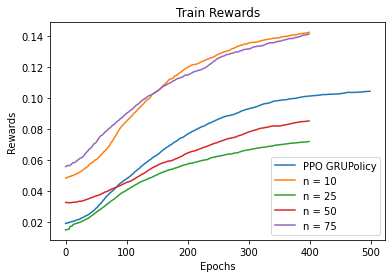

In [9]:
# Plot all rewards

import matplotlib.pyplot as plt
%matplotlib inline

plt.title('Train Rewards')
plt.plot(ema(vanilla_ppo_train_rewards, alpha=0.95))
plt.plot(ema(rl2_10_trials_rewards, alpha=0.95))
plt.plot(ema(rl2_25_trials_rewards, alpha=0.95))
plt.plot(ema(rl2_50_trials_rewards, alpha=0.95))
plt.plot(ema(rl2_75_trials_rewards, alpha=0.95))
plt.legend(['PPO GRUPolicy', 'n = 10', 'n = 25', 'n = 50', 'n = 75'])
plt.xlabel('Epochs')
plt.ylabel('Rewards')

### Experiments 2 : Changing the number of episodes per trial

In [10]:
random.seed(10)
np.random.seed(10)
torch.manual_seed(10)

rl2_4 = RL2(log_dir='./logs/RL2_Experiment_5')
rl2_4.meta_train(episodes_per_epoch=2)
rl2_10_ep_per_mdp_rewards = rl2_4.meta_test()

rl2_5 = RL2(log_dir='./logs/RL2_Experiment_6')
rl2_5.meta_train(episodes_per_epoch=5)
rl2_25_ep_per_mdp_rewards = rl2_5.meta_test()

rl2_6 = RL2(log_dir='./logs/RL2_Experiment_7')
rl2_6.meta_train(episodes_per_epoch=10)
rl2_50_ep_per_mdp_rewards = rl2_6.meta_test()

rl2_7 = RL2(log_dir='./logs/RL2_Exeriment_8')
rl2_7.meta_train(episodes_per_epoch=15)
rl2_75_ep_per_mdp_rewards = rl2_7.meta_test()


TRIAL NUMBER : 1

Start time: 02-05-2021 16:08:24
Training model on TabularEnv | Observation Space: Discrete(10) | Action Space: 2
Hyperparameters: 
{'self': <__main__.PPO object at 0x7f003a7acdd0>, 'epochs': 5, 'episodes_per_epoch': 2, 'n_value_updates': 16, 'n_policy_updates': 16, 'value_lr': 0.001, 'policy_lr': 0.0003, 'gamma': 0.99, 'epsilon': 0.1, 'max_traj_length': 1000, 'log_dir': './logs/RL2_Experiment_5/meta_train/Trial_1/', 'RENDER': False, 'PLOT_REWARDS': False, 'VERBOSE': True, 'TENSORBOARD_LOG': True}

Epoch 1: Average Episodic Reward = 0.04 | Value Loss = -0.08 | Policy Loss = 1.01
Epoch 2: Average Episodic Reward = 0.05 | Value Loss = -0.06 | Policy Loss = 0.95
Epoch 3: Average Episodic Reward = 0.05 | Value Loss = 0.00 | Policy Loss = 0.93
Epoch 4: Average Episodic Reward = 0.03 | Value Loss = -0.01 | Policy Loss = 1.01
Epoch 5: Average Episodic Reward = 0.03 | Value Loss = 0.04 | Policy Loss = 1.00

Training Completed in 0 seconds

Saved model parameters to logs/RL2_E

Text(0, 0.5, 'Rewards')

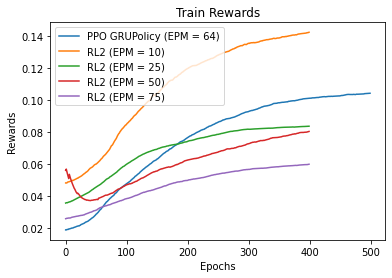

In [11]:
# Plot Rewards

plt.title('Train Rewards')
plt.plot(ema(vanilla_ppo_train_rewards, alpha=0.95))
plt.plot(ema(rl2_10_ep_per_mdp_rewards, alpha=0.95))
plt.plot(ema(rl2_25_ep_per_mdp_rewards, alpha=0.95))
plt.plot(ema(rl2_50_ep_per_mdp_rewards, alpha=0.95))
plt.plot(ema(rl2_75_ep_per_mdp_rewards, alpha=0.95))
plt.legend(['PPO GRUPolicy (EPM = 64)', 'RL2 (EPM = 10)', 'RL2 (EPM = 25)', 'RL2 (EPM = 50)', 'RL2 (EPM = 75)'])
plt.xlabel('Epochs')
plt.ylabel('Rewards')

### Ablations

Ablations performed:

* Retaining the hidden State Across Different Tasks
* Using an MLPPolicy instead of a GRUPolicy for RL$^2$

#### Retaining Hidden State across tasks

In [12]:
random.seed(10)
np.random.seed(10)
torch.manual_seed(10)

rl2_no_reset = RL2(log_dir='./logs/Ablation_1/')
rl2_no_reset.meta_train(reset_hidden_state=False)
rl2_no_reset_rewards = rl2_no_reset.meta_test()


TRIAL NUMBER : 1

Start time: 02-05-2021 17:27:44
Training model on TabularEnv | Observation Space: Discrete(10) | Action Space: 2
Hyperparameters: 
{'self': <__main__.PPO object at 0x7f0024797290>, 'epochs': 5, 'episodes_per_epoch': 2, 'n_value_updates': 16, 'n_policy_updates': 16, 'value_lr': 0.001, 'policy_lr': 0.0003, 'gamma': 0.99, 'epsilon': 0.1, 'max_traj_length': 1000, 'log_dir': './logs/Ablation_1/meta_train/Trial_1/', 'RENDER': False, 'PLOT_REWARDS': False, 'VERBOSE': True, 'TENSORBOARD_LOG': True}

Epoch 1: Average Episodic Reward = 0.04 | Value Loss = -0.07 | Policy Loss = 0.90
Epoch 2: Average Episodic Reward = 0.05 | Value Loss = -0.06 | Policy Loss = 0.85
Epoch 3: Average Episodic Reward = 0.03 | Value Loss = 0.02 | Policy Loss = 0.42
Epoch 4: Average Episodic Reward = 0.04 | Value Loss = -0.02 | Policy Loss = 0.93
Epoch 5: Average Episodic Reward = 0.07 | Value Loss = -0.11 | Policy Loss = 0.91

Training Completed in 0 seconds

Saved model parameters to logs/Ablation_1

Text(0, 0.5, 'Rewards')

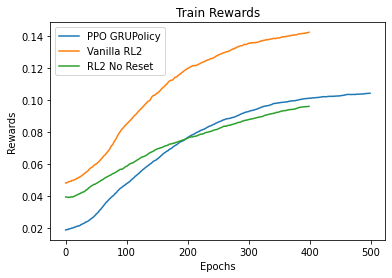

In [13]:
# Plot all rewards

import matplotlib.pyplot as plt
%matplotlib inline

plt.title('Train Rewards')
plt.plot(ema(vanilla_ppo_train_rewards, alpha=0.95))
plt.plot(ema(rl2_10_trials_rewards, alpha=0.95))
plt.plot(ema(rl2_no_reset_rewards, alpha=0.95))
plt.legend(['PPO GRUPolicy', 'Vanilla RL2', 'RL2 No Reset'])
plt.xlabel('Epochs')
plt.ylabel('Rewards')

#### RL2 with MLP Policy

##### PPO class for using MLP Policy

In [13]:
import datetime
import time
from collections import deque, namedtuple
from itertools import count
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
!wandb login

wandb.init(project='ppo-mlp', config={})

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

# Hyperparameters
EPOCHS = 200
EPISODES_PER_EPOCH = 64
POLICY_HIDDEN_LAYERS = 32
VALUE_HIDDEN_LAYERS = 32
N_POLICY_UPDATES = 16
N_VALUE_UPDATES = 16
GAMMA = 0.99
EPSILON = 0.1
VALUE_FN_LEARNING_RATE = 1e-3
POLICY_LEARNING_RATE = 3e-4
MAX_TRAJ_LENGTH = 1000


class Trajectory:
    def __init__(
        self, observations=[], actions=[], rewards=[], dones=[], logits=[],
    ):
        self.obs = observations
        self.a = actions
        self.r = rewards
        self.d = dones
        self.logits = logits
        self.len = 0

    def add(
        self,
        obs: torch.Tensor,
        a: torch.Tensor,
        r: torch.Tensor,
        d: torch.Tensor,
        logits: torch.Tensor,
    ):
        self.obs.append(obs)
        self.a.append(a)
        self.r.append(r)
        self.d.append(d)
        self.logits.append(logits)
        self.len += 1

    def disc_r(self, gamma, normalize=False):
        disc_rewards = []
        r = 0.0
        for reward in self.r[::-1]:
            r = reward + gamma * r
            disc_rewards.insert(0, r)
        disc_rewards = torch.tensor(disc_rewards, device=device, dtype=dtype)
        if normalize:
            disc_rewards = (disc_rewards - disc_rewards.mean()) / (
                disc_rewards.std() + np.finfo(np.float32).eps
            )
        return disc_rewards

    def __len__(self):
        return self.len


# Model
class PPOMLP:
    def __init__(
        self,
        env,
        policy_hidden_layers=POLICY_HIDDEN_LAYERS,
        value_hidden_layers=VALUE_HIDDEN_LAYERS,
        policy=None,
        value=None
    ):
        self.env = env
        self.env_name = 'TabularEnv'
        if policy is not None:
          self.policy=policy
        else:
          self.policy = (
              nn.Sequential(
                  nn.Linear(env.nState, policy_hidden_layers),
                  nn.Dropout(p=0.6),
                  nn.ReLU(),
                  nn.Linear(policy_hidden_layers, env.nAction),
              )
              .to(device)
              .to(dtype)
          )

        if value is not None:
          self.value=value
        else:
          self.value = (
              nn.Sequential(
                  nn.Linear(env.nState, value_hidden_layers),
                  nn.Dropout(p=0.6),
                  nn.ReLU(),
                  nn.Linear(value_hidden_layers, 1),
              )
              .to(device)
              .to(dtype)
          )

    def _update(self, batch, hp, policy_optim, value_optim):
        # process batch
        obs = [torch.stack(traj.obs)[:-1] for traj in batch]
        disc_r = [traj.disc_r(hp["gamma"], normalize=True) for traj in batch]
        a = [torch.stack(traj.a) for traj in batch]
        with torch.no_grad():
            v = [self.value(o) for o in obs]
            adv = [disc_r[i] - v[i] for i in range(len(batch))]
            old_logits = [torch.stack(traj.logits) for traj in batch]
            old_logprobs = [
                -F.cross_entropy(old_logits[i], a[i]) for i in range(len(batch))
            ]

        # update policy
        for j in range(hp["n_policy_updates"]):
            policy_loss = torch.zeros(1, device=device, dtype=dtype, requires_grad=True)
            for i, traj in enumerate(batch):
                curr_logits = self.policy(obs[i])
                curr_logprobs = -F.cross_entropy(curr_logits, a[i])
                ratio = torch.exp(curr_logprobs - old_logprobs[i])
                clipped_ratio = torch.clamp(ratio, 1 - hp["epsilon"], 1 + hp["epsilon"])
                policy_loss = (
                    policy_loss
                    + torch.min(ratio * adv[i], clipped_ratio * adv[i]).mean()
                )

            policy_loss = policy_loss / len(batch)
            policy_optim.zero_grad()
            policy_loss.backward()
            policy_optim.step()

        # update value function
        for j in range(hp["n_value_updates"]):
            value_loss = torch.zeros(1, device=device, dtype=dtype, requires_grad=True)
            for i in range(len(batch)):
                v = self.value(obs[i]).view(-1)
                value_loss = value_loss + F.mse_loss(v, disc_r[i])
            value_loss = value_loss / len(batch)
            value_optim.zero_grad()
            value_loss.backward()
            value_optim.step()

        return policy_loss.item(), value_loss.item()

    def train(
        self,
        epochs=EPOCHS,
        episodes_per_epoch=EPISODES_PER_EPOCH,
        n_value_updates=N_VALUE_UPDATES,
        n_policy_updates=N_POLICY_UPDATES,
        value_lr=VALUE_FN_LEARNING_RATE,
        policy_lr=POLICY_LEARNING_RATE,
        gamma=GAMMA,
        epsilon=EPSILON,
        max_traj_length=MAX_TRAJ_LENGTH,
        log_dir="./logs/",
        RENDER=False,
        PLOT_REWARDS=True,
        VERBOSE=False,
    ):
        """ Trains both policy and value networks """
        hp = locals()
        start_time = datetime.datetime.now()
        print(
            f"Start time: {start_time:%d-%m-%Y %H:%M:%S}"
            f"\nTraining model on {self.env_name} | "
            f"Observation Space: {self.env.nState} | "
            f"Action Space: {self.env.nAction}\n"
            f"Hyperparameters: \n{hp}\n"
        )
        log_path = Path(log_dir)
        log_path.mkdir(parents=True, exist_ok=False)

        self.policy.train()
        self.value.train()
        value_optim = torch.optim.Adam(self.value.parameters(), lr=value_lr)
        policy_optim = torch.optim.Adam(self.policy.parameters(), lr=policy_lr)
        rewards = []
        e = 0

        try:
            for epoch in range(epochs):

                epoch_rewards = []
                batch = []

                # Sample trajectories
                for _ in range(episodes_per_epoch):
                    # initialise tracking variables
                    obs = self.env.reset()
                    obs = torch.tensor(obs, device=device)
                    obs = F.one_hot(obs, num_classes=self.env.nState)
                    obs = obs.to(dtype)
                    traj = Trajectory([obs], [], [], [], [])
                    d = False
                    e += 1

                    # run for single trajectory
                    for i in range(max_traj_length):

                        a_logits = self.policy(obs)
                        a = torch.distributions.Categorical(logits=a_logits).sample()

                        obs, r, d, _ = self.env.advance(a.item())

                        obs = torch.tensor(obs, device=device)
                        obs = F.one_hot(obs, num_classes=self.env.nState)
                        obs = obs.to(dtype)
                        r = torch.tensor(r, device=device, dtype=dtype)
                        traj.add(obs, a, r, d, a_logits)

                        if d:
                            break

                    epoch_rewards.append(sum(traj.r))
                    batch.append(traj)

                # Update value and policy
                p_loss, v_loss = self._update(
                    batch, hp, policy_optim, value_optim,
                )

                # Log rewards and losses
                epoch_rewards_tensor = torch.tensor(epoch_rewards, device=device, dtype=dtype)
                avg_episode_reward = torch.mean(epoch_rewards_tensor[-episodes_per_epoch:])
                rewards.append(avg_episode_reward)

                wandb.log({
                    "policy_loss": p_loss,
                    "value_loss": v_loss,
                    "reward": avg_episode_reward,
                    "epoch": epoch,
                })

                if VERBOSE and (epoch == 0 or ((epoch + 1) % (epochs / 10)) == 0):
                    print(
                        f"Epoch {epoch+1}: Average Episodic Reward = {avg_episode_reward:.2f} |"
                        f" Value Loss = {p_loss:.2f} |"
                        f" Policy Loss = {v_loss:.2f}"
                    )

        except KeyboardInterrupt as _:
            print("\nTraining Interrupted!\n")

        finally:
            print(
                f"\nTraining Completed in {(datetime.datetime.now() - start_time).seconds} seconds"
            )
            self.save(
                log_path.joinpath(f"{self.__class__.__name__}_{self.env_name}.pt")
            )
            if PLOT_REWARDS:
                plt.plot(rewards)
                plt.savefig(
                    log_path.joinpath(
                        f"{self.__class__.__name__}_{self.env_name}_reward_plot.png"
                    )
                )
            return rewards

    def save(self, path):
        """ Save model parameters """
        torch.save(
            {
                "policy_state_dict": self.policy.state_dict(),
                "value_state_dict": self.value.state_dict(),
            },
            path,
        )
        print(f"\nSaved model parameters to {path}")

    def load(self, path=None):
        """ Load model parameters """
        if path is None:
            path = f"./models/{self.__class__.__name__}_{self.env_name}.pt"
        checkpoint = torch.load(path)
        self.policy.load_state_dict(checkpoint["policy_state_dict"])
        self.value.load_state_dict(checkpoint["value_state_dict"])
        print(f"\nLoaded model parameters from {path}")

    def eval(self, episodes, render=False):
        """ Evaluates model performance """

        print(f"\nEvaluating model for {episodes} episodes ...\n")
        start_time = datetime.datetime.now()
        self.policy.eval()
        rewards = []

        for episode in range(episodes):

            observation = self.env.reset()
            observation = torch.tensor(observation, device=device)
            observation = F.one_hot(observation, num_classes=self.env.nState)
            observation = observation.to(dtype)
            done = False
            episode_rewards = []

            while not done:

                logits = self.policy(observation)
                action = torch.distributions.Categorical(logits=logits).sample()
                next_observation, reward, done, _ = self.env.advance(action.item())
                episode_rewards.append(float(reward))
                next_observation = torch.tensor(next_observation, device=device)
                next_observation = F.one_hot(next_observation, num_classes=self.env.nState)
                next_observation = next_observation.to(dtype)
                observation = next_observation

            total_episode_reward = sum(episode_rewards)
            rewards.append(total_episode_reward)
            print(
                f"Episode {episode+1}: Total Episode Reward = {total_episode_reward:.2f}"
            )
            rewards.append(total_episode_reward)

        print(f"\nAverage Reward for an episode = {np.mean(rewards):.2f}")
        print(
            f"Evaluation Completed in {(datetime.datetime.now() - start_time).seconds} seconds"
        )

##### Running PPO with MLP Policy on river swim environment

Start time: 03-05-2021 07:37:20
Training model on TabularEnv | Observation Space: 10 | Action Space: 2
Hyperparameters: 
{'self': <__main__.PPOMLP object at 0x7fdc564d4a50>, 'epochs': 500, 'episodes_per_epoch': 64, 'n_value_updates': 16, 'n_policy_updates': 16, 'value_lr': 0.001, 'policy_lr': 0.0003, 'gamma': 0.99, 'epsilon': 0.1, 'max_traj_length': 1000, 'log_dir': './logs/ppo_mlp_policy', 'RENDER': False, 'PLOT_REWARDS': True, 'VERBOSE': True}

Epoch 1: Average Episodic Reward = 0.03 | Value Loss = -0.07 | Policy Loss = 0.95
Epoch 50: Average Episodic Reward = 0.11 | Value Loss = -0.00 | Policy Loss = 0.95
Epoch 100: Average Episodic Reward = 0.11 | Value Loss = -0.01 | Policy Loss = 0.95
Epoch 150: Average Episodic Reward = 0.11 | Value Loss = -0.00 | Policy Loss = 0.95
Epoch 200: Average Episodic Reward = 0.11 | Value Loss = 0.00 | Policy Loss = 0.95
Epoch 250: Average Episodic Reward = 0.11 | Value Loss = -0.00 | Policy Loss = 0.95
Epoch 300: Average Episodic Reward = 0.11 | Value

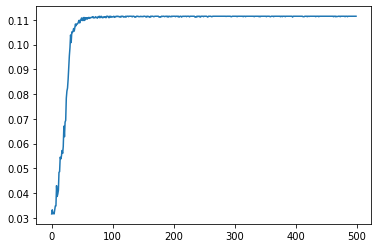

In [14]:
random.seed(10)
np.random.seed(10)
torch.manual_seed(10)

env = make_riverSwim(nState=10, epLen=20)
agent = PPOMLP(env)
vanilla_ppo_mlp_rewards = agent.train(epochs=500, VERBOSE=True, PLOT_REWARDS=True, log_dir='./logs/ppo_mlp_policy')

##### Running RL$^2$ on PPO with MLP Policy

In [20]:
random.seed(10)
np.random.seed(10)
torch.manual_seed(10)

rl2_mlp = RL2(policy_type='mlp', log_dir='./logs/Ablation_2')
rl2_mlp.meta_train(reset_hidden_state=False)
rl2_mlp_policy_rewards = rl2_mlp.meta_test()


TRIAL NUMBER : 1

Start time: 03-05-2021 08:10:49
Training model on TabularEnv | Observation Space: 10 | Action Space: 2
Hyperparameters: 
{'self': <__main__.PPOMLP object at 0x7fdc5ed03f10>, 'epochs': 5, 'episodes_per_epoch': 2, 'n_value_updates': 16, 'n_policy_updates': 16, 'value_lr': 0.001, 'policy_lr': 0.0003, 'gamma': 0.99, 'epsilon': 0.1, 'max_traj_length': 1000, 'log_dir': './logs/Ablation_2/meta_train/Trial_1/', 'RENDER': False, 'PLOT_REWARDS': False, 'VERBOSE': True}

Epoch 1: Average Episodic Reward = 0.07 | Value Loss = -0.00 | Policy Loss = 0.95
Epoch 2: Average Episodic Reward = 0.06 | Value Loss = -0.03 | Policy Loss = 0.99
Epoch 3: Average Episodic Reward = 0.06 | Value Loss = -0.03 | Policy Loss = 0.95
Epoch 4: Average Episodic Reward = 0.05 | Value Loss = -0.00 | Policy Loss = 0.92
Epoch 5: Average Episodic Reward = 0.05 | Value Loss = -0.00 | Policy Loss = 1.01

Training Completed in 0 seconds

Saved model parameters to logs/Ablation_2/meta_train/Trial_1/PPOMLP_Tabu

We compare the performances of PPOGRU, PPOMLP, RL$^2$ on PPOGRU and RL$^2$ on PPOMLP. RL$^2$ on PPOGRU and RL$^2$ on PPOMLP are used with same hyperparameters wrt to the MDP (no. of trials, no. of epochs per trial, etc.)

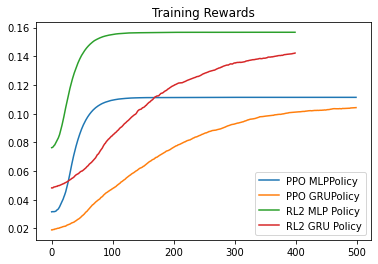

In [23]:
# Plotting rewards

import matplotlib.pyplot as plt
%matplotlib inline

plt.title('Training Rewards')
plt.plot(ema(vanilla_ppo_mlp_rewards, alpha=0.95))
plt.plot(ema(vanilla_ppo_train_rewards, alpha=0.95))
plt.plot(ema(rl2_mlp_policy_rewards, alpha=0.95))
plt.plot(ema(rl2_10_trials_rewards, alpha=0.95))
plt.legend(['PPO MLPPolicy', 'PPO GRUPolicy', 'RL2 MLP Policy', 'RL2 GRU Policy'])